In [8]:
# LOAD DEPENDENCIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
import shap

In [9]:
# IMPORT
df = (pd.read_csv('model.csv'))
prediction = (pd.read_csv('predictions.csv'))

Preprocessing

In [10]:
# Remove whitespaces
df.columns = df.columns.str.replace(' ', '')
prediction.columns = prediction.columns.str.replace(' ', '')

In [11]:
# Check model for nulls
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
age_days,0,0.0
n_tokens_title,0,0.0
topic_quality,0,0.0
topic_shipping,0,0.0
topic_packaging,0,0.0
topic_description,0,0.0
topic_others,0,0.0
global_subjectivity,0,0.0
global_sentiment_polarity,0,0.0
global_rate_positive_words,0,0.0


In [12]:
# Check prediction for nulls
total = prediction.isnull().sum().sort_values(ascending=False)
percent = (prediction.isnull().sum()/prediction.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
age_days,0,0.0
rate_positive_words,0,0.0
topic_quality,0,0.0
topic_shipping,0,0.0
topic_packaging,0,0.0
topic_description,0,0.0
topic_others,0,0.0
global_subjectivity,0,0.0
global_sentiment_polarity,0,0.0
global_rate_positive_words,0,0.0


In [13]:
# Outlier removal and Categorical variable encoding

# Function to recursively identify categorical variables and store their names in a list
def find_categorical_variables(df):
    categorical_vars = []
    for column in df.columns:
        if df[column].dtype == 'object':
            categorical_vars.append(column)
    return categorical_vars

# Function to convert categorical variables to numerical using LabelEncoder
def label_encode_categorical(df, categorical_vars):
    label_encoders = {}
    for var in categorical_vars:
        label_encoder = LabelEncoder()
        df[var] = label_encoder.fit_transform(df[var])
        label_encoders[var] = label_encoder
    return df, label_encoders

# Function to remove outliers based on a threshold of 3 standard deviations
def remove_outliers(df):
    z_scores = np.abs((df - df.mean()) / df.std())
    df = df[(z_scores < 10).all(axis=1)]
    return df

# Recursive identification of categorical variables
categorical_vars = find_categorical_variables(df)
categorical_vars_p = find_categorical_variables(prediction)

# Convert categorical variables to numerical using LabelEncoder
data_encoded, label_encoders = label_encode_categorical(df.copy(), categorical_vars)
data_encoded_p, label_encoders_p = label_encode_categorical(prediction.copy(), categorical_vars_p)

# Remove outliers based on a threshold of 3 standard deviations
data_restored = pd.DataFrame(remove_outliers(data_encoded))
data_restored_p = pd.DataFrame(remove_outliers(data_encoded_p))

num_rows = df.shape[0]
print("Number of rows in df:", num_rows)

num_rows = data_restored.shape[0]
print("Number of rows in df after removing outliers:", num_rows)

print()

num_rows_p = prediction.shape[0]
print("Number of rows in prediction:", num_rows_p)

num_rows_p = data_restored_p.shape[0]
print("Number of rows in prediction after removing outliers:", num_rows_p)

Number of rows in df: 28000
Number of rows in df after removing outliers: 27572

Number of rows in prediction: 10000
Number of rows in prediction after removing outliers: 9860


Feature Engineering

In [14]:
# Calculate new columns for model
data_restored['keyword_avg_score'] = data_restored['kw_avg_avg']
data_restored['keyword_min_score'] = (data_restored['kw_avg_min'] + data_restored['kw_max_min']) / 2
data_restored['keyword_max_score'] = (data_restored['kw_avg_max'] + data_restored['kw_min_max']) / 2
data_restored['keyword_max_score_proportion'] = data_restored['kw_max_max']/843300
data_restored['keyword_min_score_proportion'] = (data_restored['kw_min_min']+2)/217


data_restored['rate_neutral_words'] = 1 - (data_restored['global_rate_positive_words'] + data_restored['global_rate_negative_words'])
data_restored['rate_positive_words'] = data_restored['global_rate_positive_words']
data_restored['rate_negative_words'] = data_restored['global_rate_negative_words']

# Drop the original columns
data_restored = data_restored.drop(columns=['kw_avg_avg', 'kw_max_avg', 'kw_min_avg', 
                      'kw_avg_min', 'kw_max_min', 'kw_min_min', 
                      'kw_avg_max', 'kw_max_max', 'kw_min_max',
                      'abs_title_subjectivity', 'abs_title_sentiment_polarity',
                      'global_rate_positive_words', 'global_rate_negative_words'])

print(data_restored['keyword_avg_score'], data_restored['keyword_min_score'], data_restored['keyword_max_score'], data_restored['keyword_max_score_proportion'], data_restored['keyword_min_score_proportion'], data_restored['rate_neutral_words'], data_restored['rate_positive_words'], data_restored['rate_negative_words'])

0        2761.659526
1        2809.707695
2        2560.433166
3        2050.198539
4        3180.772322
            ...     
27995    4609.315068
27996    3111.038721
27997    2674.580075
27998    2397.225951
27999    3161.575636
Name: keyword_avg_score, Length: 27572, dtype: float64 0        3703.812500
1         250.600000
2         313.071429
3         383.000000
4         707.625000
            ...     
27995    1060.875000
27996     473.500000
27997     192.666667
27998     330.000000
27999     408.100000
Name: keyword_min_score, Length: 27572, dtype: float64 0         58005.000000
1        176760.000000
2        112678.571428
3         12166.666667
4         76862.500000
             ...      
27995     29737.500000
27996    185187.500000
27997    189808.333333
27998    116640.000000
27999     27180.000000
Name: keyword_max_score, Length: 27572, dtype: float64 0        1.000000
1        1.000000
2        1.000000
3        0.046721
4        1.000000
           ...   
27995    0.0

In [15]:
# Calculate new columns for prediction
data_restored_p['keyword_avg_score'] = data_restored_p['kw_avg_avg']
data_restored_p['keyword_min_score'] = (data_restored_p['kw_avg_min'] + data_restored_p['kw_max_min']) / 2
data_restored_p['keyword_max_score'] = (data_restored_p['kw_avg_max'] + data_restored_p['kw_min_max']) / 2
data_restored_p['keyword_max_score_proportion'] = data_restored_p['kw_max_max'] / 843300
data_restored_p['keyword_min_score_proportion'] = (data_restored_p['kw_min_min'] + 2) / 217

data_restored_p['rate_neutral_words'] = 1 - (data_restored_p['global_rate_positive_words'] + data_restored_p['global_rate_negative_words'])
data_restored_p['rate_positive_words'] = data_restored_p['global_rate_positive_words']
data_restored_p['rate_negative_words'] = data_restored_p['global_rate_negative_words']

# Drop the original columns
data_restored_p = data_restored_p.drop(columns=['kw_avg_avg', 'kw_max_avg', 'kw_min_avg', 
                                                'kw_avg_min', 'kw_max_min', 'kw_min_min', 
                                                'kw_avg_max', 'kw_max_max', 'kw_min_max',
                                                'abs_title_subjectivity', 'abs_title_sentiment_polarity',
                                                'global_rate_positive_words', 'global_rate_negative_words'])

print(data_restored_p['keyword_avg_score'], data_restored_p['keyword_min_score'], data_restored_p['keyword_max_score'], data_restored_p['keyword_max_score_proportion'], data_restored_p['keyword_min_score_proportion'], data_restored_p['rate_neutral_words'], data_restored_p['rate_positive_words'], data_restored_p['rate_negative_words'])


0       2936.574087
1       2873.258039
2       3149.947286
3       1603.704504
4       3187.346159
           ...     
9995    2807.859607
9996    3827.146170
9997    2370.112332
9998    3661.252183
9999    1885.655404
Name: keyword_avg_score, Length: 9860, dtype: float64 0        473.000000
1        786.375000
2       2359.888889
3        903.900000
4        474.222222
           ...     
9995     301.600000
9996    6777.250000
9997     461.555556
9998     479.000000
9999    1467.214286
Name: keyword_min_score, Length: 9860, dtype: float64 0       114521.428572
1         7485.000000
2        14811.111111
3         6583.333333
4        93522.222222
            ...      
9995    158630.000000
9996     86237.500000
9997    136916.666667
9998     45800.000000
9999     13135.000000
Name: keyword_max_score, Length: 9860, dtype: float64 0       1.000000
1       0.033203
2       0.081940
3       0.044350
4       1.000000
          ...   
9995    1.000000
9996    1.000000
9997    1.000000
999

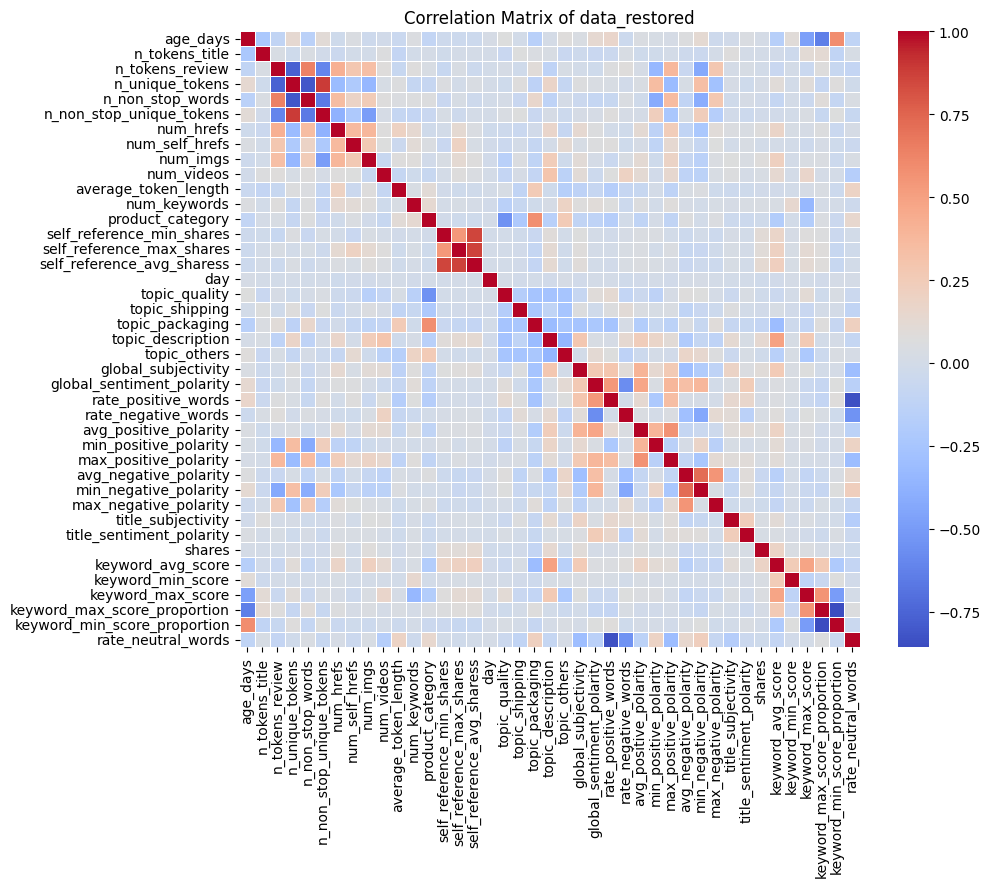

In [53]:
# Compute the correlation matrix
correlation_matrix = data_restored.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of model')
plt.show()

In [54]:
# Compute the correlation of all features with 'shares'
correlation_with_shares = data_restored.corr()['shares'].sort_values(ascending=False)

# Print the top 10 correlated variables
print(correlation_with_shares[1:11])

keyword_avg_score             0.184114
topic_description             0.132930
self_reference_avg_sharess    0.122146
self_reference_min_shares     0.107329
global_subjectivity           0.099589
self_reference_max_shares     0.098359
num_imgs                      0.080166
num_hrefs                     0.075196
avg_positive_polarity         0.056890
keyword_max_score             0.055502
Name: shares, dtype: float64


Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_restored.drop(columns=['shares']), data_restored['shares'], test_size=0.2, random_state=40)

Scale

In [17]:
# Scale Model

# Get the list of all columns except the target column 'shares'
all_columns = data_restored.drop(columns=['shares']).columns.tolist()

# Get the list of numeric columns by subtracting categorical columns
numeric_columns = [col for col in all_columns if col not in categorical_vars]

# Initialize StandardScaler
scaler = MinMaxScaler()

# Scale numeric columns and preserve column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns)

In [18]:
# Scale Prediction

all_columns_p = data_restored_p.columns.tolist()

# Get the list of numeric columns by subtracting categorical columns
numeric_columns_p = [col for col in all_columns_p if col not in categorical_vars_p]

# Initialize StandardScaler
scaler_p = MinMaxScaler()

# Scale numeric columns and preserve column names
prediction_scaled = pd.DataFrame(scaler_p.fit_transform(data_restored_p[numeric_columns]), columns=numeric_columns)

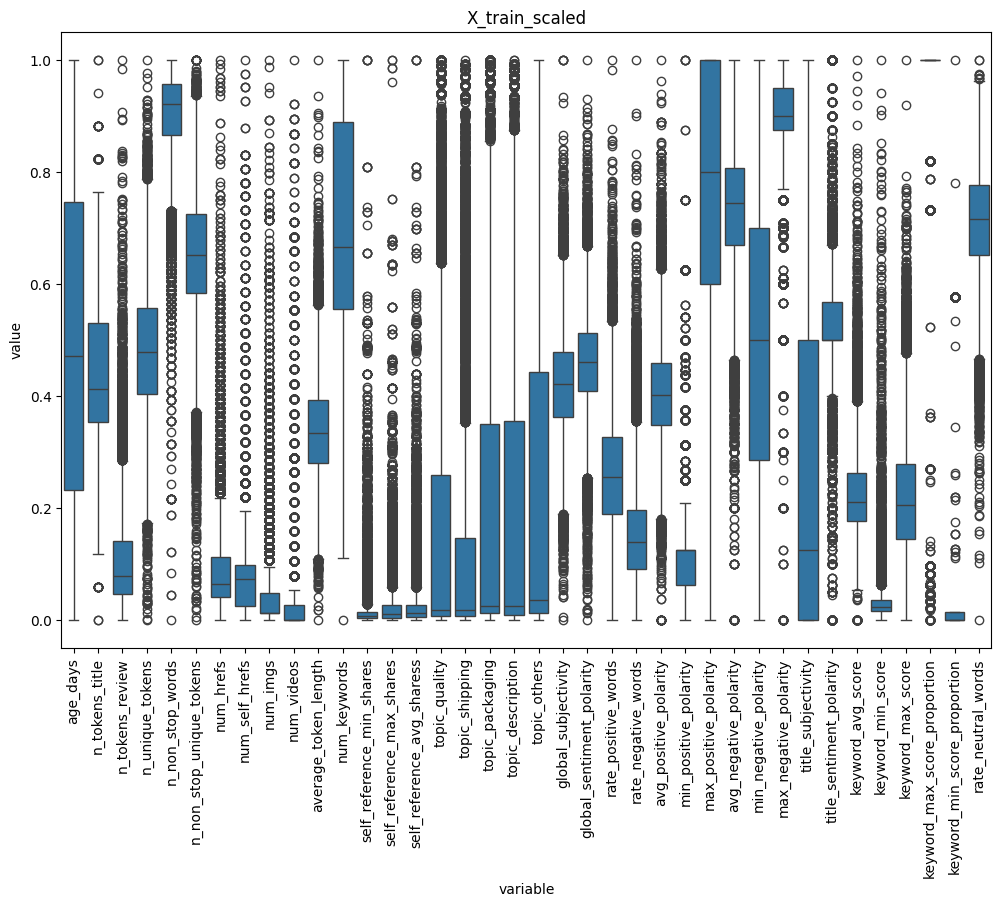

Number of rows in X_train: 22057
Number of rows in y_train: 22057


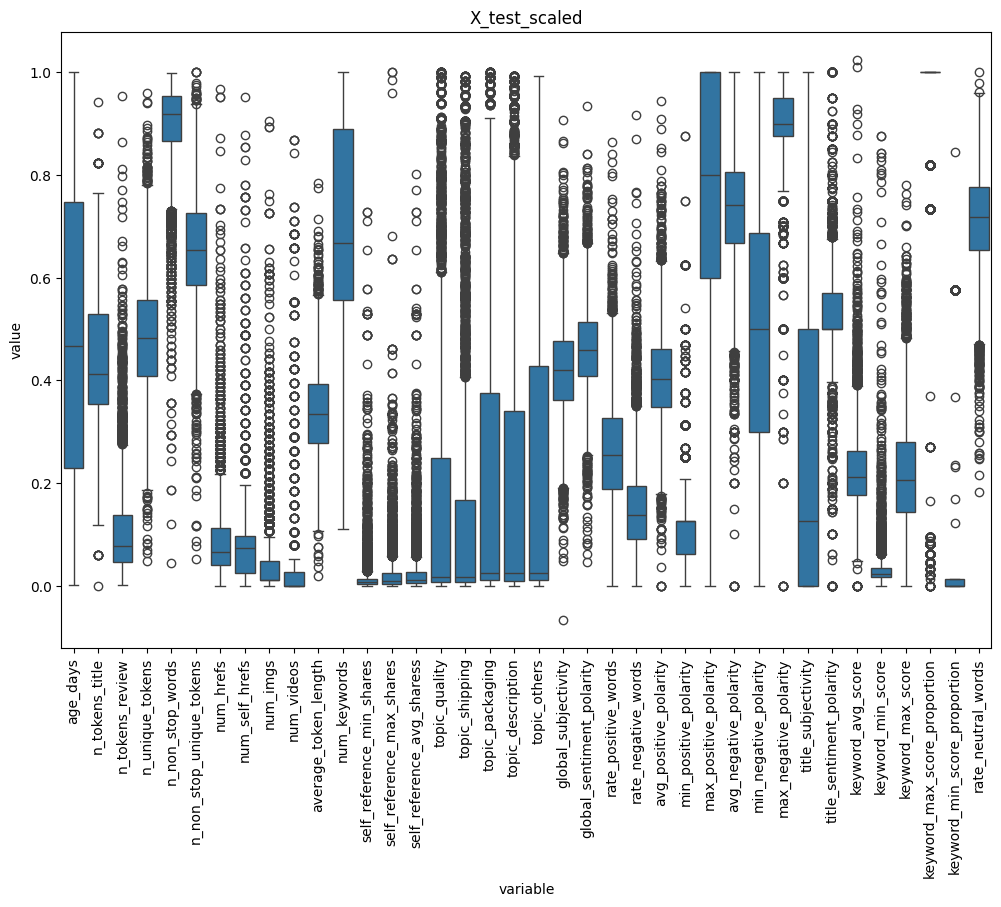

Number of rows in X_test: 5515
Number of rows in y_train: 5515


In [19]:
# EDA model scaled

X_train_viz = pd.DataFrame(X_train_scaled)
X_test_viz = pd.DataFrame(X_test_scaled)

m_melted = X_train_viz.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=m_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_scaled")
plt.show()

num_rows = X_train_viz.shape[0]
print("Number of rows in X_train:", num_rows)

num_rows = y_train.shape[0]
print("Number of rows in y_train:", num_rows)

p_melted = X_test_viz.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=p_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_test_scaled")
plt.show()

num_rows = X_test_viz.shape[0]
print("Number of rows in X_test:", num_rows)

num_rows = y_test.shape[0]
print("Number of rows in y_train:", num_rows)

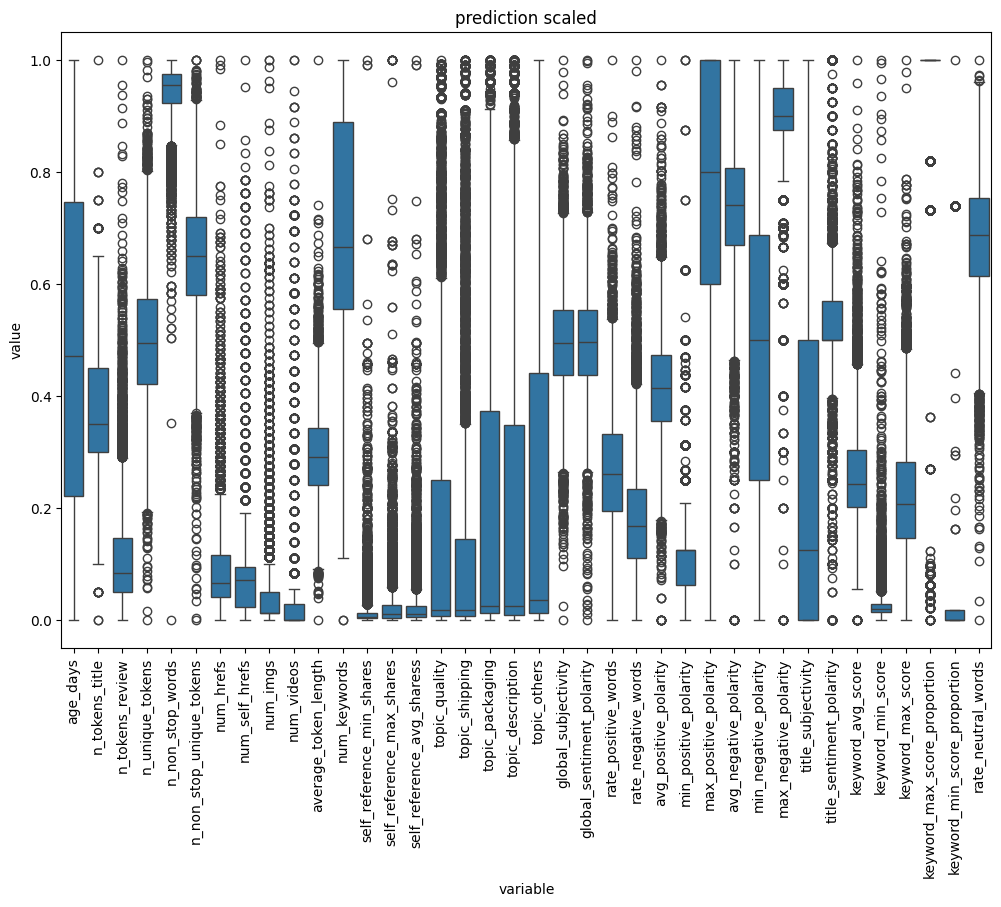

Number of rows in X_train: 9860


In [20]:
# EDA prediction

m_melted_p = prediction_scaled.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=m_melted_p)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("prediction scaled")
plt.show()

num_rows_p = prediction_scaled.shape[0]
print("Number of rows in X_train:", num_rows_p)

In [21]:
# Concatenate encoded categorical columns with scaled numeric columns

X_train_concat = pd.concat([X_train[categorical_vars].reset_index(drop=True), X_train_scaled.reset_index(drop=True)], axis=1)
X_test_concat = pd.concat([X_test[categorical_vars].reset_index(drop=True), X_test_scaled.reset_index(drop=True)], axis=1)

In [22]:
# Concatenate encoded categorical columns with scaled numeric columns prediction

prediction_concat = pd.concat([data_restored_p[categorical_vars_p].reset_index(drop=True), prediction_scaled.reset_index(drop=True)], axis=1)

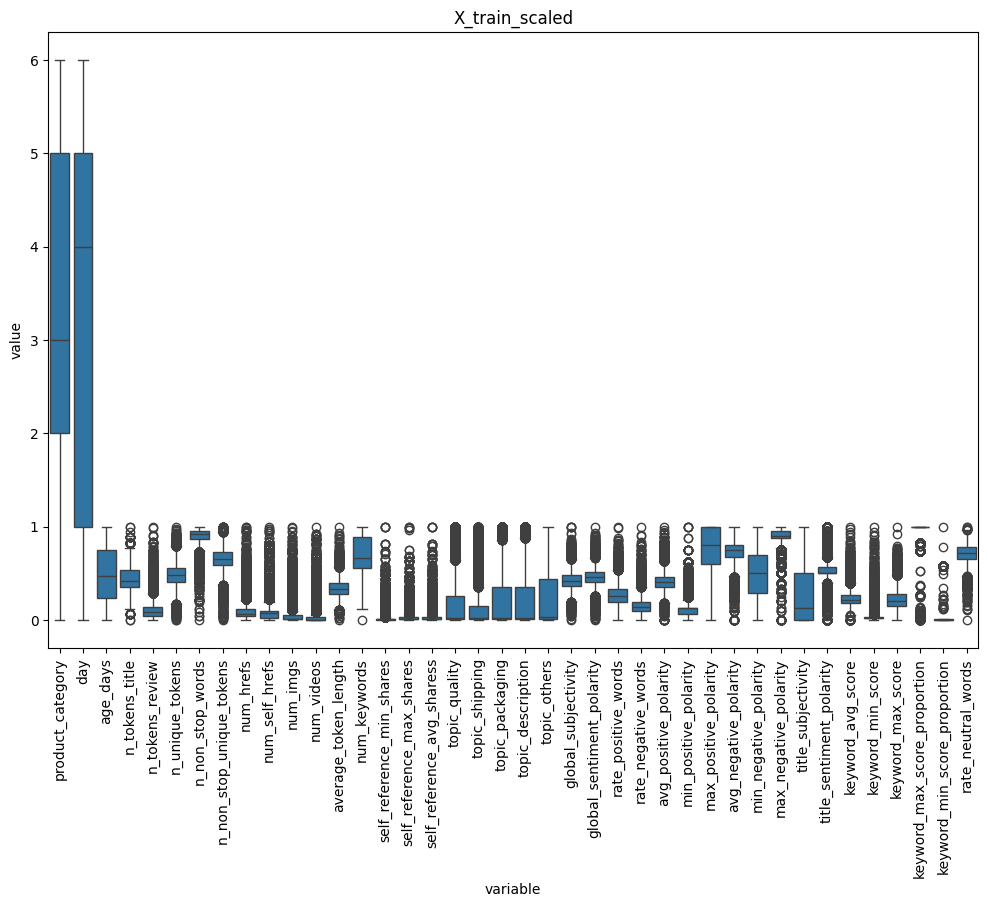

Number of rows in X_train: 22057
Number of rows in y_train: 22057


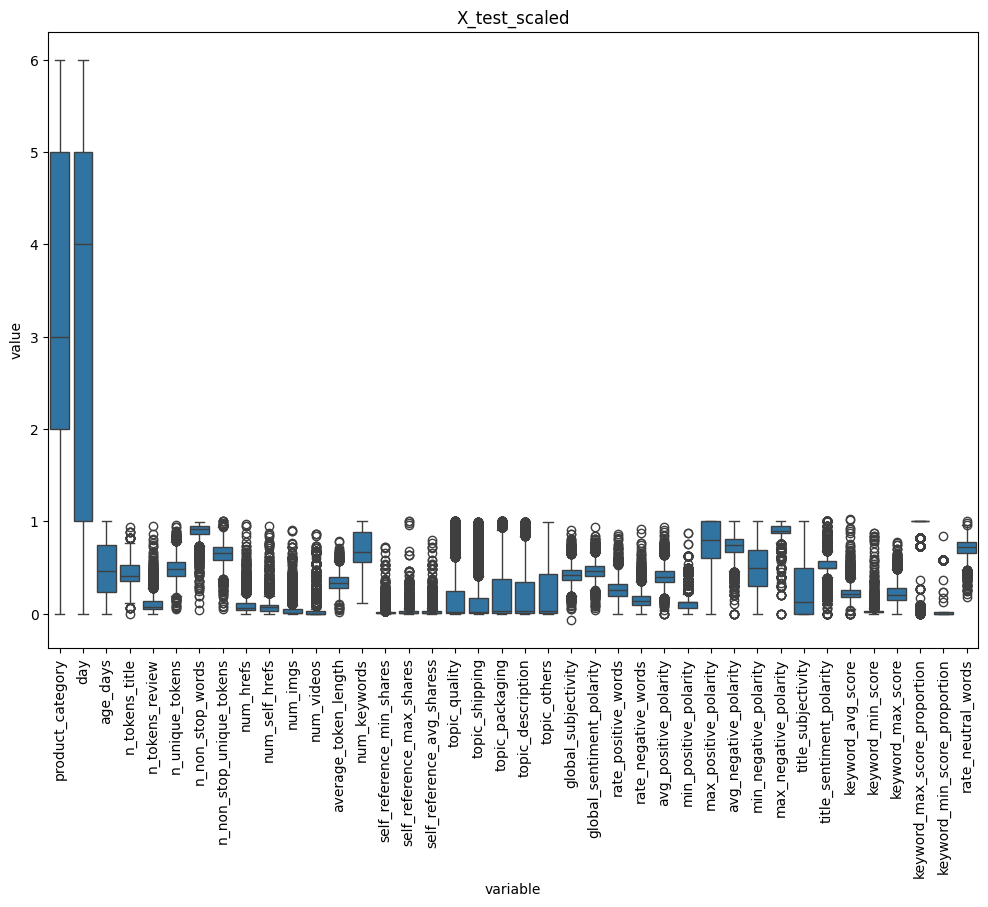

Number of rows in X_test: 5515
Number of rows in y_test: 5515


In [23]:
# EDA model

m_melted = X_train_concat.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=m_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_scaled")
plt.show()

num_rows = X_train_concat.shape[0]
print("Number of rows in X_train:", num_rows)

num_rows = y_train.shape[0]
print("Number of rows in y_train:", num_rows)

p_melted = X_test_concat.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=p_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_test_scaled")
plt.show()

num_rows = X_test_concat.shape[0]
print("Number of rows in X_test:", num_rows)

num_rows = y_test.shape[0]
print("Number of rows in y_test:", num_rows)

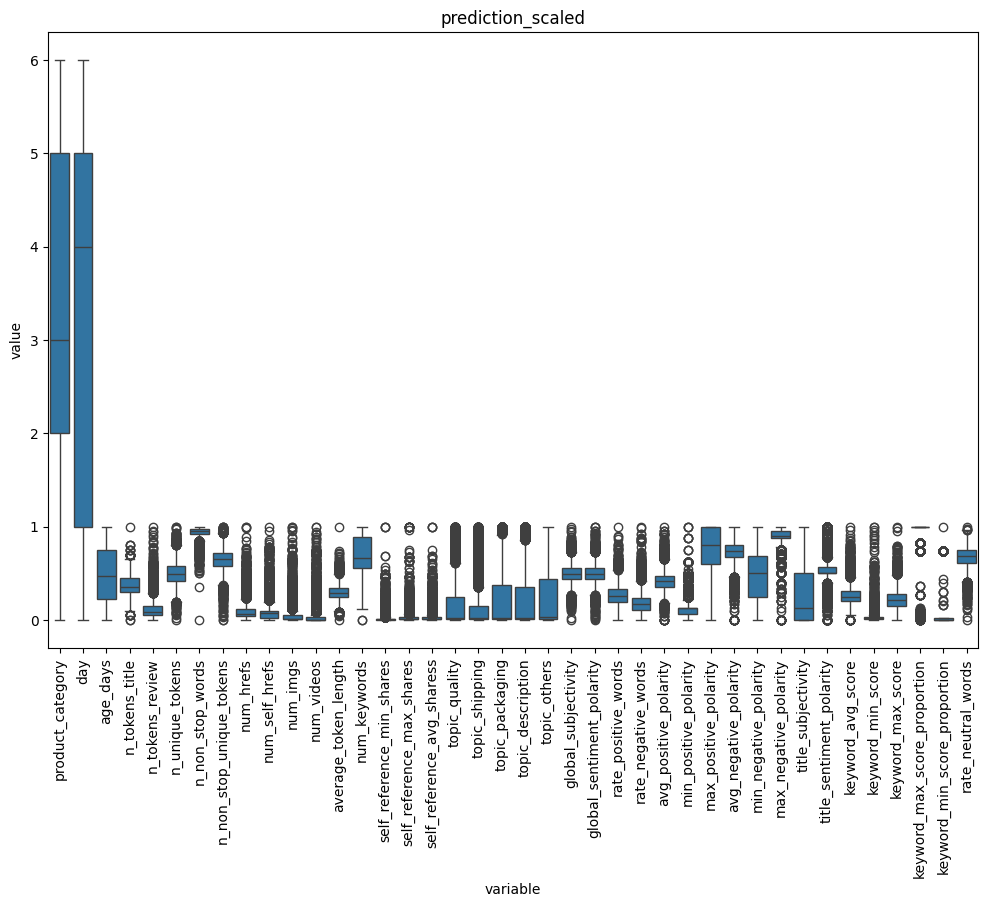

Number of rows in prediction: 9860


In [24]:
# EDA prediction

m_melted_pc = prediction_concat.melt()


plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=m_melted_pc)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("prediction_scaled")
plt.show()

num_rows_pc = prediction_concat.shape[0]
print("Number of rows in prediction:", num_rows_pc)

In [25]:
mean_values = np.mean(X_train_concat, axis=0)
std_dev_values = np.std(X_train_concat, axis=0)

print("Mean values for each feature:", mean_values)
print("Standard deviation for each feature:", std_dev_values)

Mean values for each feature: product_category                3.302262
day                             3.294374
age_days                        0.487600
n_tokens_title                  0.433977
n_tokens_review                 0.106371
n_unique_tokens                 0.483077
n_non_stop_words                0.897538
n_non_stop_unique_tokens        0.651656
num_hrefs                       0.089520
num_self_hrefs                  0.081831
num_imgs                        0.054244
num_videos                      0.031260
average_token_length            0.338646
num_keywords                    0.692801
self_reference_min_shares       0.018854
self_reference_max_shares       0.027062
self_reference_avg_sharess      0.028144
topic_quality                   0.187609
topic_shipping                  0.135904
topic_packaging                 0.219779
topic_description               0.216019
topic_others                    0.244375
global_subjectivity             0.421121
global_sentiment_polarity  

In [26]:
# Log transformation
X_train_abs = X_train_concat[numeric_columns].abs()
X_test_abs = X_test_concat[numeric_columns].abs()

X_train_cat = X_train_concat[categorical_vars]
X_test_cat = X_test_concat[categorical_vars]

X_train_log = np.log1p(X_train_abs)
X_test_log = np.log1p(X_test_abs)

X_train_final = pd.DataFrame(pd.concat([X_train_log.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1))
X_test_final = pd.DataFrame(pd.concat([X_test_log.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1))

y_train_log = pd.DataFrame(np.log1p(y_train))
y_test_log = pd.DataFrame(np.log1p(y_test))

In [27]:
# Log transformation prediction
prediction_abs = prediction_concat[numeric_columns_p].abs()
prediction_cat = prediction_concat[categorical_vars_p]
prediction_log = np.log1p(prediction_abs)
prediction_final = pd.DataFrame(pd.concat([prediction_log.reset_index(drop=True), prediction_cat.reset_index(drop=True)], axis=1))

count     22057.000000
mean       3172.167385
std        6568.811288
min          22.000000
25%         939.000000
50%        1400.000000
75%        2800.000000
max      128900.000000
Name: shares, dtype: float64
Skewness: 8.131275
Kurtosis: 94.102667


<Axes: xlabel='shares', ylabel='Count'>

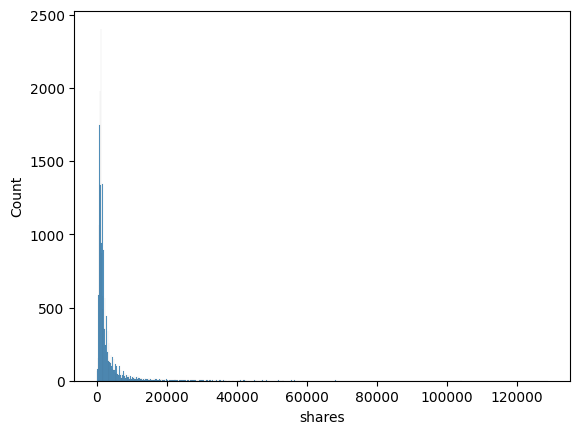

In [28]:
# Y train before log transformation

y_train_viz = pd.DataFrame(y_train)

print(y_train_viz['shares'].describe())
print("Skewness: %f" % y_train_viz['shares'].skew())
print("Kurtosis: %f" % y_train_viz['shares'].kurt())
sns.histplot(y_train_viz['shares'])

count    22057.000000
mean         7.469540
std          0.919192
min          3.135494
25%          6.845880
50%          7.244942
75%          7.937732
max         11.766800
Name: shares, dtype: float64
Skewness: 0.998052
Kurtosis: 1.767515


<Axes: xlabel='shares', ylabel='Count'>

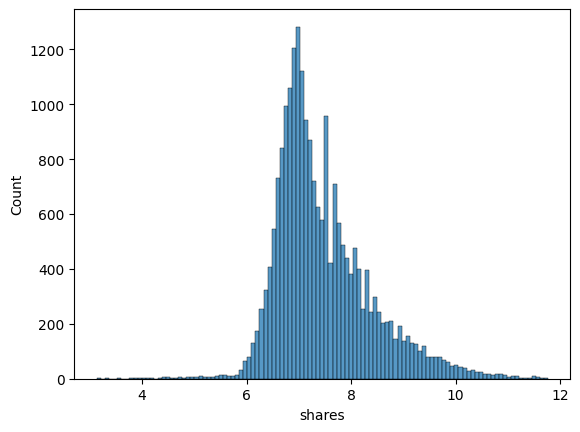

In [29]:
# Y train After log transformation
y_train_viz2 = pd.DataFrame(y_train_log)

print(y_train_viz2['shares'].describe())
print("Skewness: %f" % y_train_viz2['shares'].skew())
print("Kurtosis: %f" % y_train_viz2['shares'].kurt())
sns.histplot(y_train_viz2['shares'])

In [30]:
mean_values = np.mean(X_train_final, axis=0)
std_dev_values = np.std(X_train_final, axis=0)

print("Mean values for each feature:", mean_values)
print("Standard deviation for each feature:", std_dev_values)

Mean values for each feature: age_days                        0.377220
n_tokens_title                  0.356717
n_tokens_review                 0.098124
n_unique_tokens                 0.391039
n_non_stop_words                0.639483
n_non_stop_unique_tokens        0.499303
num_hrefs                       0.083006
num_self_hrefs                  0.075846
num_imgs                        0.049370
num_videos                      0.027452
average_token_length            0.289550
num_keywords                    0.518495
self_reference_min_shares       0.017660
self_reference_max_shares       0.025455
self_reference_avg_sharess      0.026419
topic_quality                   0.146489
topic_shipping                  0.109138
topic_packaging                 0.170639
topic_description               0.166456
topic_others                    0.189316
global_subjectivity             0.349252
global_sentiment_polarity       0.377467
rate_positive_words             0.230018
rate_negative_words        

Data Augmentation With GAN

In [31]:
# Define generator architecture
random_noise_dim = 50

generator = Sequential()
generator.add(Dense(512, input_dim=random_noise_dim, activation='relu'))
generator.add(Dense(128, activation='relu'))
generator.add(Dense(X_train_final.shape[1], activation='linear'))  # Output layer with same shape as input data
generator.compile(loss='mean_squared_error', optimizer='adam')

# Define discriminator architecture for binary classification
discriminator = Sequential()
discriminator.add(Dense(256, input_dim=X_train_final.shape[1], activation='relu'))
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False  # We don't want to update discriminator weights during generator training
gan_input = Input(shape=(random_noise_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training loop for GAN
epochs = 1000
batch_size = 8

for epoch in range(epochs):
    # Generate synthetic data
    noise = np.random.normal(0, 1, size=(batch_size, random_noise_dim))
    generated_data = generator.predict(noise)

    # Combine real and synthetic data
    X_combined = np.concatenate([X_train_final, generated_data])
    y_combined = np.concatenate([np.ones((len(X_train_final), 1)), np.zeros((len(generated_data), 1))])  # Label real data as '1' and synthetic data as '0'

    # Train discriminator
    discriminator_loss = discriminator.train_on_batch(X_combined, y_combined)

    # Train generator (with discriminator frozen)
    noise = np.random.normal(0, 1, size=(batch_size, random_noise_dim))
    y_fake = np.ones(batch_size)  # We want the discriminator to predict real for generated data
    gan_loss = gan.train_on_batch(noise, y_fake)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Discriminator Loss: {discriminator_loss}, GAN Loss: {gan_loss}")

# Generate synthetic data for training
num_synthetic_samples = 500  # Adjust as needed
noise = np.random.normal(0, 1, size=(num_synthetic_samples, random_noise_dim))
synthetic_data = generator.predict(noise)

# Convert synthetic data to DataFrame with original feature names
original_feature_names = X_train_final.columns.tolist()
synthetic_df = pd.DataFrame(synthetic_data, columns=original_feature_names)

# Combine synthetic data with original training data
X_train_augmented = pd.concat([X_train_final, synthetic_df])
y_train_augmented = np.concatenate([y_train_log, np.ones((num_synthetic_samples, 1))])  # Label synthetic data as '1'

# Shuffle augmented data
augmented_indices = np.arange(len(X_train_augmented))
np.random.shuffle(augmented_indices)
X_train_augmented = X_train_augmented.iloc[augmented_indices]
y_train_augmented = y_train_augmented[augmented_indices]

# Combine synthetic data with original test data
X_test_augmented = pd.concat([X_test_final, synthetic_df.iloc[:num_synthetic_samples // 2]])
y_test_augmented = np.concatenate([y_test_log, np.ones((num_synthetic_samples // 2, 1))])  # Label synthetic data as '1'

# Shuffle augmented test data
augmented_indices_test = np.arange(len(X_test_augmented))
np.random.shuffle(augmented_indices_test)
X_test_augmented = X_test_augmented.iloc[augmented_indices_test]
y_test_augmented = y_test_augmented[augmented_indices_test]

1/1 [==============================] - 0s 100ms/step
Epoch: 0, Discriminator Loss: [0.6533240079879761, 0.7212327122688293], GAN Loss: 0.6749956607818604
1/1 [==============================] - 0s 18ms/step
Epoch: 100, Discriminator Loss: [0.007166277151554823, 0.9996374249458313], GAN Loss: 0.0016862154006958008
1/1 [==============================] - 0s 19ms/step
Epoch: 200, Discriminator Loss: [0.012583720497786999, 0.9996374249458313], GAN Loss: 0.05816420912742615
1/1 [==============================] - 0s 19ms/step
Epoch: 300, Discriminator Loss: [0.0003930914681404829, 0.9999547004699707], GAN Loss: 3.3851215839385986
1/1 [==============================] - 0s 18ms/step
Epoch: 400, Discriminator Loss: [0.0008783602970652282, 0.9998640418052673], GAN Loss: 4.162224769592285
1/1 [==============================] - 0s 18ms/step
Epoch: 500, Discriminator Loss: [0.001743560889735818, 0.9996374249458313], GAN Loss: 0.04148155078291893
1/1 [==============================] - 0s 18ms/step
Epo

In [32]:
X_train_aug = pd.DataFrame(X_train_augmented)
y_train_aug = pd.DataFrame(y_train_augmented)

In [33]:
X_test_aug = pd.DataFrame(X_test_augmented)
y_test_aug = pd.DataFrame(y_test_augmented)

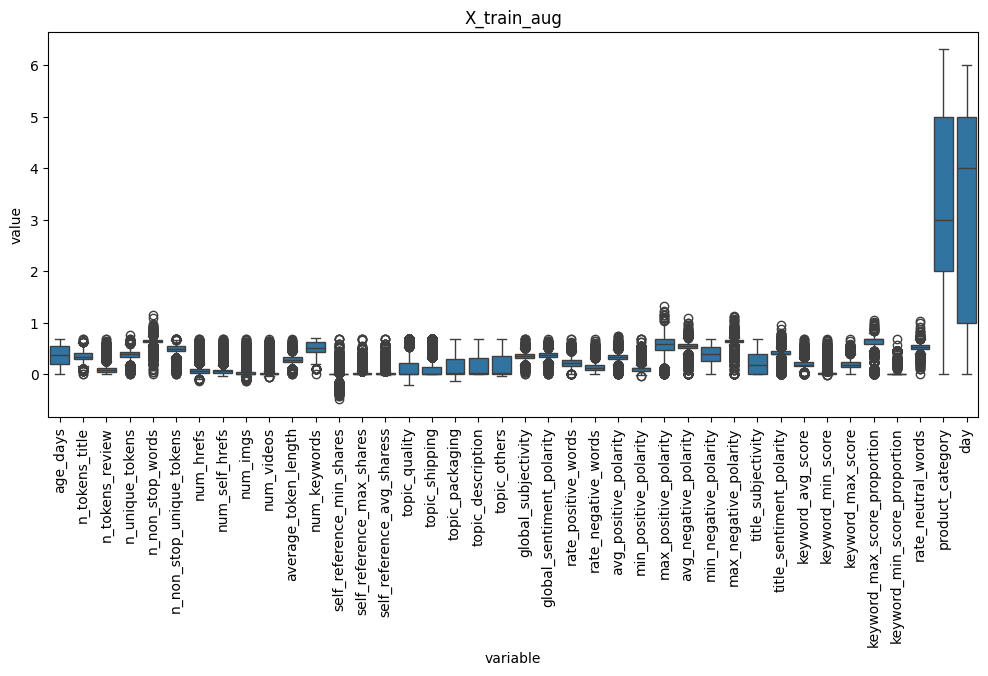

Number of rows in synthetic: 22557


In [47]:
# EDA synthetic

m_melted_pc = X_train_aug.melt()

plt.figure(figsize=(12, 5))
sns.boxplot(x='variable', y='value', data=m_melted_pc)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_aug")
plt.show()

num_rows_pc = X_train_aug.shape[0]
print("Number of rows in synthetic:", num_rows_pc)

In [35]:
X_train_final_num_rows = X_train_final.shape[0]
X_train_aug_num_rows = X_train_aug.shape[0]
print("Rows generated for X_train:", (X_train_aug_num_rows - X_train_final_num_rows))

y_train_log_num_rows = y_train_log.shape[0]
y_train_aug_num_rows = y_train_aug.shape[0]
print("Rows generated for y_train:", (y_train_aug_num_rows - y_train_log_num_rows))

X_test_final_num_rows = X_test_final.shape[0]
X_test_aug_num_rows = X_test_aug.shape[0]
print("Rows generated for X_test:", (X_test_aug_num_rows - X_test_final_num_rows))

y_test_log_num_rows = y_test_log.shape[0]
y_test_aug_num_rows = y_test_aug.shape[0]
print("Rows generated for y_test:", (y_test_aug_num_rows - y_test_log_num_rows))

print("X_train_aug rows:", X_train_aug_num_rows)
print("X_test_aug rows:", X_test_aug_num_rows)
print("y_train_aug rows:", y_train_aug_num_rows)
print("y_test_aug rows:", y_test_aug_num_rows)

Rows generated for X_train: 500
Rows generated for y_train: 500
Rows generated for X_test: 250
Rows generated for y_test: 250
X_train_aug rows: 22557
X_test_aug rows: 5765
y_train_aug rows: 22557
y_test_aug rows: 5765


Safety Net For Categorical Variable Limits

In [36]:
# Convert to DataFrame
X_train_aug = pd.DataFrame(X_train_aug)
X_test_aug = pd.DataFrame(X_test_aug)
y_train_aug = pd.DataFrame(y_train_aug)
y_test_aug = pd.DataFrame(y_test_aug)

# Apply filtering on X_train_aug and X_test_aug
X_train_aug_filtered = X_train_aug[(X_train_aug['day'] <= 6) & (X_train_aug['product_category'] <= 6)]
X_test_aug_filtered = X_test_aug[(X_test_aug['day'] <= 6) & (X_test_aug['product_category'] <= 6)]

# Get the indices of rows to remove
indices_to_remove_train = X_train_aug.index.difference(X_train_aug_filtered.index)
indices_to_remove_test = X_test_aug.index.difference(X_test_aug_filtered.index)

# Remove corresponding rows from y_train_aug and y_test_aug
y_train_aug_filtered = y_train_aug.drop(indices_to_remove_train)
y_test_aug_filtered = y_test_aug.drop(indices_to_remove_test)



X_train_aug_num_rows_filtered = X_train_aug_filtered.shape[0]
y_train_aug_num_rows_filtered = y_train_aug_filtered.shape[0]
X_test_aug_num_rows_filtered = X_test_aug_filtered.shape[0]
y_test_aug_num_rows_filtered = y_test_aug_filtered.shape[0]


print("X_train_aug rows:", X_train_aug_num_rows_filtered)
print("X_test_aug rows:", X_test_aug_num_rows_filtered)
print("y_train_aug rows:", y_train_aug_num_rows_filtered)
print("y_test_aug rows:", y_test_aug_num_rows_filtered)

X_train_aug rows: 22556
X_test_aug rows: 5764
y_train_aug rows: 22557
y_test_aug rows: 5765


Visualize

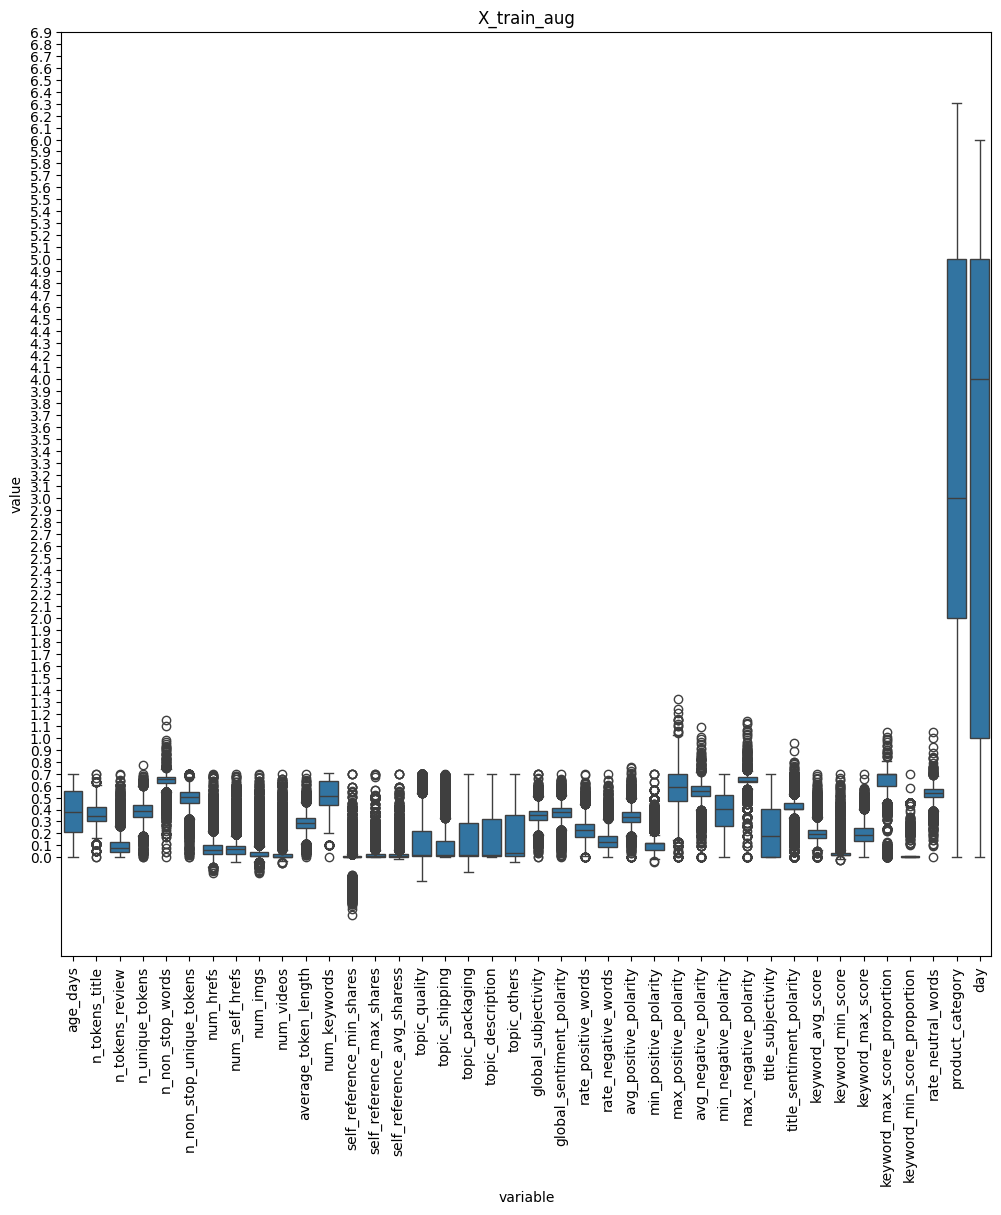

In [37]:
# X_train_aug Distribution
p_melted = X_train_aug.melt()

plt.figure(figsize=(12, 12))
sns.boxplot(x='variable', y='value', data=p_melted)
plt.yticks(np.arange(0, 7, 0.1))
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_aug")
plt.show()

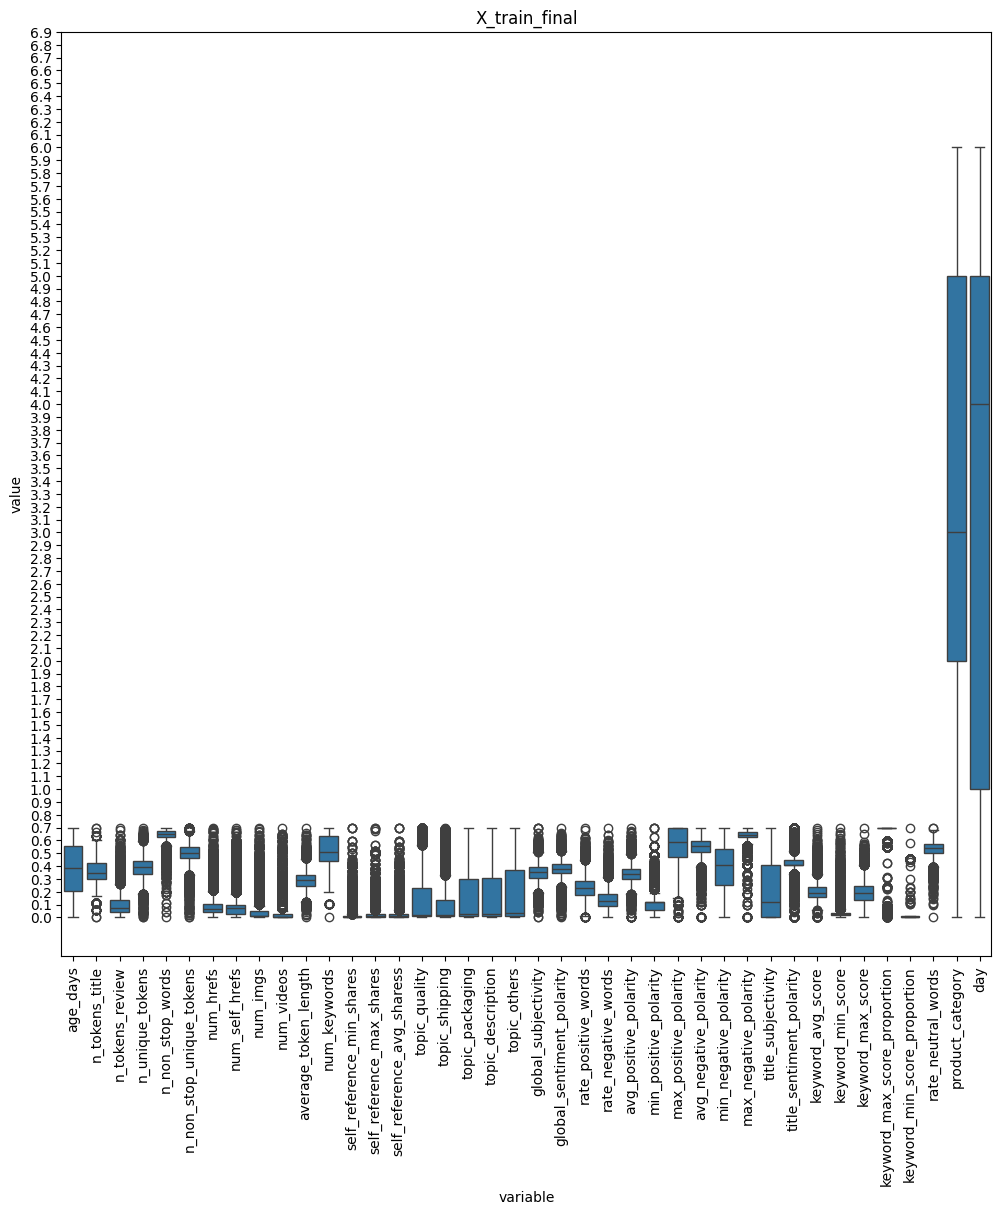

In [38]:
# X_train_final Distribution
p_melted = X_train_final.melt()

plt.figure(figsize=(12, 12))
sns.boxplot(x='variable', y='value', data=p_melted)
plt.yticks(np.arange(0, 7, 0.1))
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_final")
plt.show()

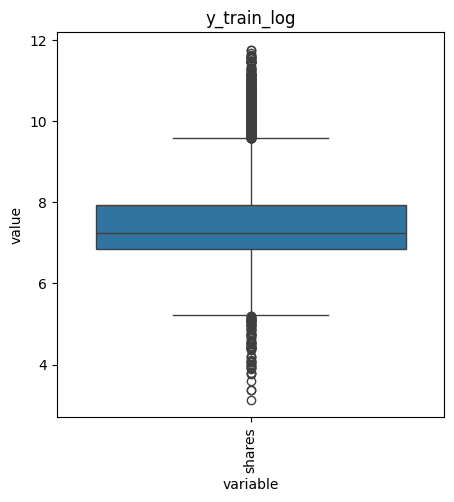

In [39]:
# y_train_log Distribution
p_melted = y_train_log.melt()

plt.figure(figsize=(5, 5))
sns.boxplot(x='variable', y='value', data=p_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("y_train_log")
plt.show()

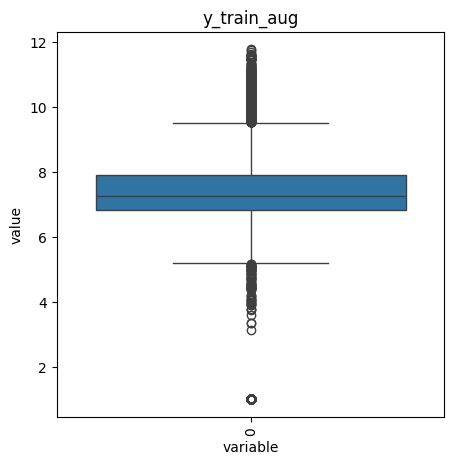

In [51]:
# y_train_aug Distribution
p_melted = y_train_aug.melt()

plt.figure(figsize=(5, 5))
sns.boxplot(x='variable', y='value', data=p_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("y_train_aug")
plt.show()

Regression Using XGBoost

In [41]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2]
}

# Create XGBoost regressor
xg_reg = XGBRegressor(objective='reg:squarederror')

# Perform Random Search
random_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=param_grid, 
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=5, 
                                   verbose=2, random_state=42, n_jobs=-1)

# Fit the Random Search to the training data
random_search.fit(X_train_aug, y_train_aug)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = -random_search.best_score_

print("Best Hyperparameters:")
print(best_params)
print("Best Mean Absolute Error:", best_score)

# Make predictions on the training and test data using the best model
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train_aug)
y_test_pred = best_model.predict(X_test_aug)

# Calculate evaluation metrics
train_mse = mean_squared_error(y_train_aug, y_train_pred)
test_mse = mean_squared_error(y_test_aug, y_test_pred)

train_mae = mean_absolute_error(y_train_aug, y_train_pred)
test_mae = mean_absolute_error(y_test_aug, y_test_pred)

train_r2 = r2_score(y_train_aug, y_train_pred)
test_r2 = r2_score(y_test_aug, y_test_pred)

# Calculate adjusted R-squared for training data
n_train = X_train_aug.shape[0]
p_train = X_train_aug.shape[1]
train_adj_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate adjusted R-squared for test data
n_test = X_test_aug.shape[0]
p_test = X_test_aug.shape[1]
test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Print evaluation metrics
print("\nTraining Metrics:")
print("Mean Squared Error (MSE):", train_mse)
print("Mean Absolute Error (MAE):", train_mae)
print("R-squared (R2):", train_r2)
print("Adjusted R-squared:", train_adj_r2)

print("\nTest Metrics:")
print("Mean Squared Error (MSE):", test_mse)
print("Mean Absolute Error (MAE):", test_mae)
print("R-squared (R2):", test_r2)
print("Adjusted R-squared:", test_adj_r2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters:
{'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 0}
Best Mean Absolute Error: 0.6019985990410166

Training Metrics:
Mean Squared Error (MSE): 0.4981708359938941
Mean Absolute Error (MAE): 0.5223132998775026
R-squared (R2): 0.7125952563154381
Adjusted R-squared: 0.7120846776270662

Test Metrics:
Mean Squared Error (MSE): 0.6302635344359566
Mean Absolute Error (MAE): 0.5771969851278731
R-squared (R2): 0.7459854110732913
Adjusted R-squared: 0.7442103265944184


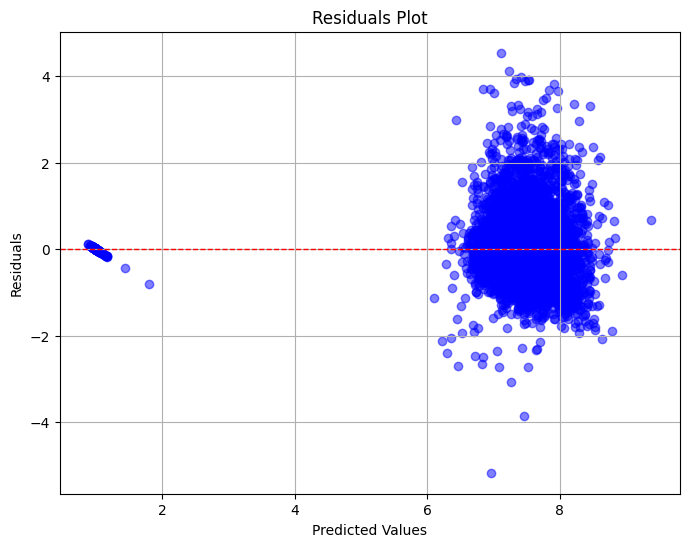

Mean of the residuals: -0.013203626485652922


In [42]:
# Residuals Graph

# Extract values from DataFrame
y_test_aug_values = y_test_aug.values.ravel()  # Convert DataFrame to a flattened NumPy array

# Calculate residuals
residuals = y_test_aug_values - y_test_pred
residuals_mean = residuals.mean()

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

print("Mean of the residuals:", residuals_mean)

Feature Importance: SHAP

In [43]:
# Create a SHAP explainer object
explainer = shap.Explainer(best_model, X_train_aug)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_aug)

# Get feature importance
feature_importance = np.abs(shap_values).mean(axis=0)

# Sort feature importance
sorted_idx = np.argsort(feature_importance)

 99%|===================| 5707/5765 [00:32<00:00]        

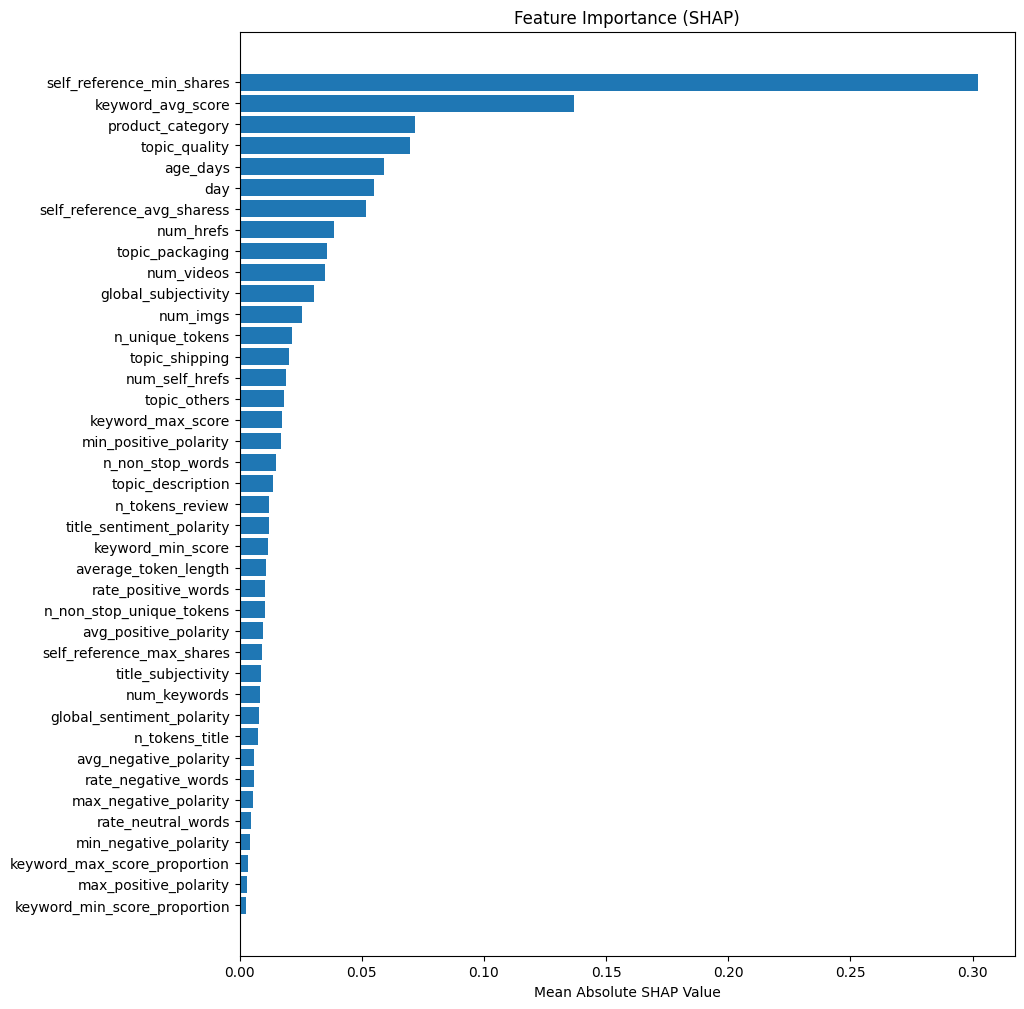

In [44]:
# Plot feature importance
plt.figure(figsize=(10, 12))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_importance)), [X_train_aug.columns[i] for i in sorted_idx])
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance (SHAP)')
plt.show()

Step 7: Generate Predictions


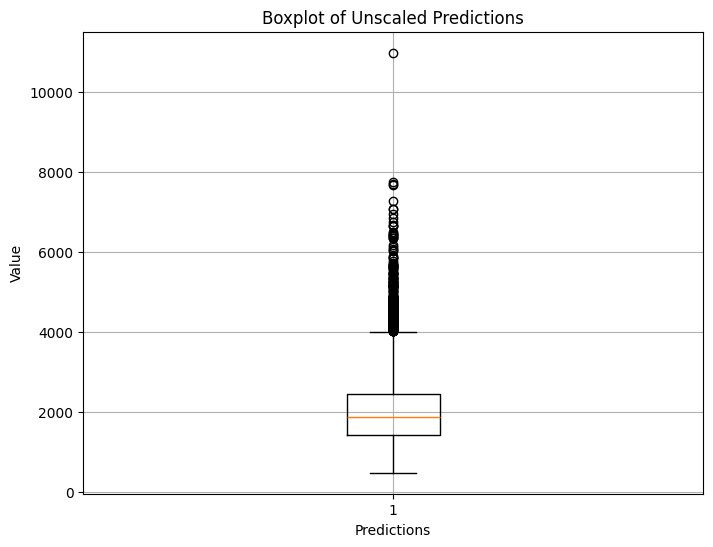

Number of rows in the dataset: 9860
Step 8: Saving predictions to a CSV file
Predictions saved successfully


In [46]:
# GENERATE PREDICTIONS
print("Step 7: Generate Predictions")

# Predict on the unseen data using the best model
predictions_best_model = best_model.predict(prediction_final)

# Apply inverse log transformation
unlog = np.expm1(predictions_best_model)

# Round and cast predictions to integer
unscaled_predictions = np.round(unlog).astype(int)

# Create a boxplot of unscaled predictions
plt.figure(figsize=(8, 6))
plt.boxplot(unscaled_predictions)
plt.title('Boxplot of Unscaled Predictions')
plt.xlabel('Predictions')
plt.ylabel('Value')
plt.grid(True)
plt.show()

num_rows = unscaled_predictions.shape[0]
print("Number of rows in the dataset:", num_rows)

# Save predictions to a CSV file
print("Step 8: Saving predictions to a CSV file")
predictions_df = pd.DataFrame({'Target': unscaled_predictions.flatten()})
predictions_df.to_csv('Colangelo_Gentile.csv', index=False)
print("Predictions saved successfully")